# Image segmentation

In [6]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def open_img(img_path):
    img = cv2.imread(img_path)
    
    (left, upper, right, lower) = (572, 271, 1330, 940)
    img_cropped = img[upper:lower, left:right]
    
    return img_cropped

In [8]:
image_no = 3
bg = open_img("img_raw/bg.png")
img1 = open_img(f"img_raw/{image_no}.png")

bg_gray = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

In [9]:
img2 = open_img(f"img_probe/2.png")

In [10]:
# cv2.imshow('bg',bg)
# cv2.imshow('1',img1)
# cv2.imshow('2',img2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [11]:
def segmentation(image_no, in_folder, out_folder):
    img_path = f"{in_folder}/{image_no}.png"
    img1 = open_img(img_path)
    
    img1_sub = cv2.subtract(img1, bg)
    img1_gray = cv2.cvtColor(img1_sub, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(img1_gray,5,255,cv2.THRESH_BINARY)

    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(thresh1,kernel,iterations = 2)
    dilation = cv2.dilate(erosion,kernel,iterations = 2)
    
    img1_masked = cv2.bitwise_and(img1, img1, mask=dilation)
#     cv2.imshow('ee', img1_masked)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    a = []
    nrows = 15
    ncols = 17

    size = 40
    w_start = 35
    h_start = 31

    y_start = h_start
    for i in range(nrows):
        if(i%2==0):
            y_end = y_start + size
        elif(i%2==1):
            y_end = y_start + (size+1)

        img_row = []
        x_start = w_start
        for j in range(ncols):
            if(j%2==0):
                x_end = x_start + (size+1)
            elif(j%2==1):
                x_end = x_start + size

            img_to_write = img1_masked[y_start:y_start+size, x_start:x_start+size]
            
            dir_path = f"{out_folder}/img_{image_no}"
            if(not os.path.exists(dir_path)):
                os.mkdir(dir_path)
            
            first_digit = str(i+1)
            second_digit = str(j+1)
            if(i+1<10):
                first_digit = f"0{first_digit}"
            if(j+1<10):
                second_digit = f"0{second_digit}"

            cv2.imwrite(f"{dir_path}/img_{image_no}_{first_digit}_{second_digit}.png", img_to_write)
            img_row.append(img_to_write)
            
            x_start = x_end

        a.append(img_row)
        y_start = y_end
        
    return a

In [12]:
# for i in range(1,11):
#     segmentation(i, "img_raw", "img_proc")

In [13]:
for i in range(18):
    segmentation(i, "img_probe", "img_probe")

# Label the objects

## Histogram

In [14]:
def calc_hist(img):
    img = img[upper_t:lower_t, left_t:right_t]
    
    chans = cv2.split(img)
    colors = ("b", "g", "r")
    
#     plt.figure()
    
    hist_arr = []
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    # loop over the image channels
    for (chan, color) in zip(chans, colors):
#         plt.title("'Flattened' Color Histogram")
#         plt.xlabel("Bins")
#         plt.ylabel("# of Pixels")
        
        hist = cv2.calcHist([chan], [0], None, [128], [0, 256])
        norm_hist = cv2.normalize(hist, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        hist_arr.append(norm_hist)
        
        # plot the histogram
#         axes[0].plot(norm_hist, color = color)
#         axes[0].set_xlim([0, 128])
    
#     axes[1].imshow(img[::,::,::-1])
#     plt.show()    
#     plt.close()
    
    return hist_arr

In [15]:
def plot_hist(hist):
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    
    chans = (0, 1, 2)
    colors = ("b", "g", "r")
    for (chan, color) in zip(chans, colors):
        plt.plot(hist[chan], color=color)
    
    plt.show()
    plt.close()

# Fetch images

In [16]:
labeled_folder_path = "img_gallery"
labels = [str(i) for i in range(4)]
label_str = ['BG', 'APPL', 'BODY', 'HEAD']
n_label = int(labels[-1]) + 1

(upper_t, lower_t, left_t, right_t) = (6, 34, 6, 34)

## Labeled

In [32]:
def calc_all_hist():
    hist_all_label = []
    img_all_label = []
    
    labeled_folder_path = "img_gallery"
    labels = [str(i) for i in range(4)]
    label_str = ['BG', 'APPL', 'BODY', 'HEAD']
    n_label = int(labels[-1]) + 1
    
    for label in labels:
        labeled_path = f"{labeled_folder_path}/{label}/"

        hist_label = []        
        img_label = []
        for filename in os.listdir(labeled_path):
#             print(labeled_path + filename)
            img = cv2.imread(labeled_path + filename)
            img_crp = crop_img(img)
            
            hist_img = calc_hist(img_crp)
            hist_label.append(hist_img)
            img_label.append(img_crp)
        hist_all_label.append(hist_label)
        img_all_label.append(img_label)
        
    return hist_all_label, img_all_label

## Probe

In [18]:
def crop_img(img):
    (upper_t, lower_t, left_t, right_t) = (6, 34, 6, 34)
    img = img[upper_t:lower_t, left_t:right_t]
    
    return img

In [19]:
def predict_img_label(img, hist_all_label, threshold):
    hist_img = calc_hist(img)
    
    matched_i = -1
    matched_j = -1
    max_coeff = 0
    
    for i in range(n_label):
        for j in range(len(hist_all_label[i])):
            sum_diff = 0
            diffs = []
            for chan in range(3):
                diff = cv2.compareHist(hist_img[chan], hist_all_label[i][j][chan], cv2.HISTCMP_CORREL)
                sum_diff += diff
                diffs.append(diff)

            avg_diff = sum_diff/3
            to_print = False
            if(avg_diff > threshold):
                to_print = True
                for k in range(3):
                    if(diffs[k]<threshold):
                        to_print = False

            if(to_print):
                if(avg_diff>max_coeff):
                    max_coeff = avg_diff
                    matched_i = i
                    matched_j = j
    
    if(max_coeff!=0):
        return matched_i, matched_j, max_coeff
    
    return 0, -1, 0

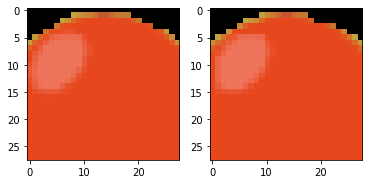

filename = img_0_02_06.png, label = APPL, i = 1, j = 7, Max coeff. = 0.9999032942372469
----------------------------------------------------------


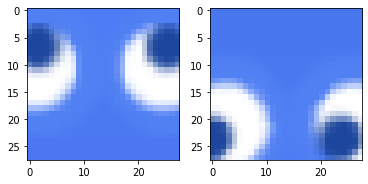

filename = img_0_05_06.png, label = HEAD, i = 3, j = 3, Max coeff. = 0.794231361407967
----------------------------------------------------------


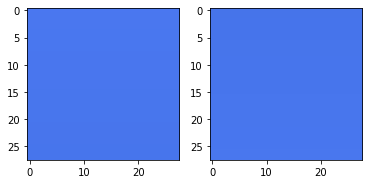

filename = img_0_06_06.png, label = BODY, i = 2, j = 19, Max coeff. = 0.9290257267593754
----------------------------------------------------------


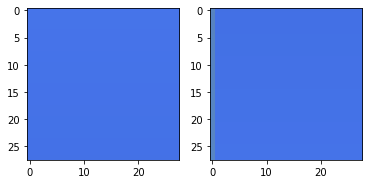

filename = img_0_07_06.png, label = BODY, i = 2, j = 18, Max coeff. = 0.9418388215831611
----------------------------------------------------------


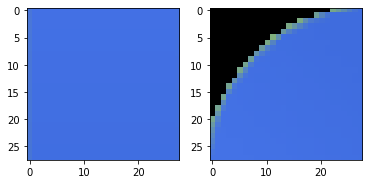

filename = img_0_08_06.png, label = BODY, i = 2, j = 3, Max coeff. = 0.9355225666839669
----------------------------------------------------------


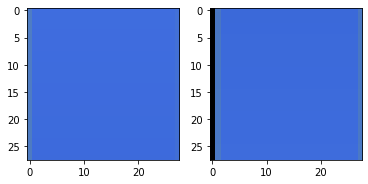

filename = img_0_09_06.png, label = BODY, i = 2, j = 16, Max coeff. = 0.7149144016092065
----------------------------------------------------------


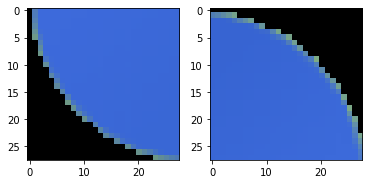

filename = img_0_10_06.png, label = BODY, i = 2, j = 5, Max coeff. = 0.9332707946894274
----------------------------------------------------------


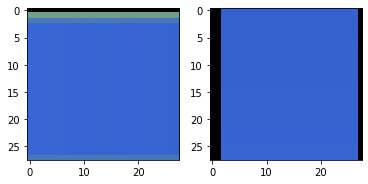

filename = img_0_10_07.png, label = BODY, i = 2, j = 13, Max coeff. = 0.46602523132616575
----------------------------------------------------------


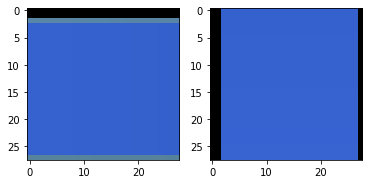

filename = img_0_10_08.png, label = BODY, i = 2, j = 13, Max coeff. = 0.26653875708293223
----------------------------------------------------------


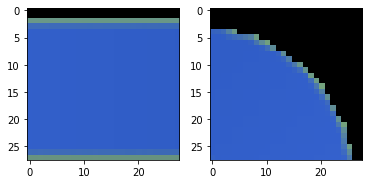

filename = img_0_10_09.png, label = BODY, i = 2, j = 11, Max coeff. = 0.34175777086118364
----------------------------------------------------------


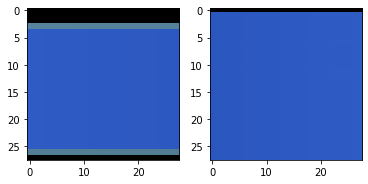

filename = img_0_10_10.png, label = BODY, i = 2, j = 8, Max coeff. = 0.9387615472328436
----------------------------------------------------------


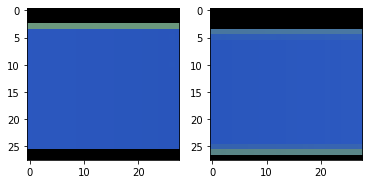

filename = img_0_10_11.png, label = BODY, i = 2, j = 10, Max coeff. = 0.47502622223063556
----------------------------------------------------------


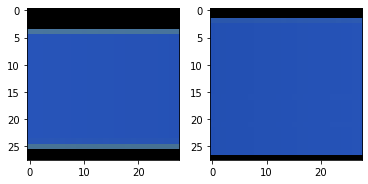

filename = img_0_10_12.png, label = BODY, i = 2, j = 1, Max coeff. = 0.6471084152323395
----------------------------------------------------------


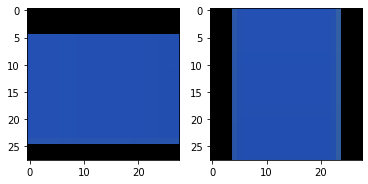

filename = img_0_10_13.png, label = BODY, i = 2, j = 7, Max coeff. = 0.9252308360136453
----------------------------------------------------------


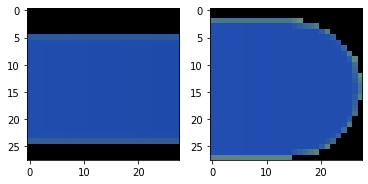

filename = img_0_10_14.png, label = BODY, i = 2, j = 0, Max coeff. = 0.30422984926550983
----------------------------------------------------------


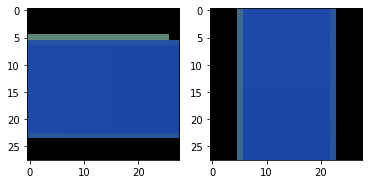

filename = img_0_10_15.png, label = BODY, i = 2, j = 12, Max coeff. = 0.9598515607968244
----------------------------------------------------------


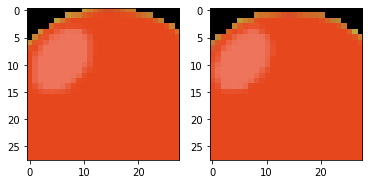

filename = img_1_02_02.png, label = APPL, i = 1, j = 4, Max coeff. = 0.9998291341417659
----------------------------------------------------------


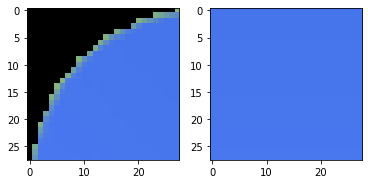

filename = img_1_02_03.png, label = BODY, i = 2, j = 19, Max coeff. = 0.9467829329557933
----------------------------------------------------------


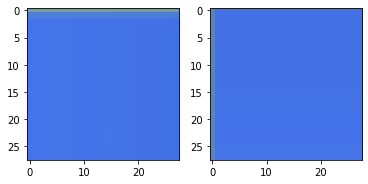

filename = img_1_02_04.png, label = BODY, i = 2, j = 18, Max coeff. = 0.959586256405956
----------------------------------------------------------


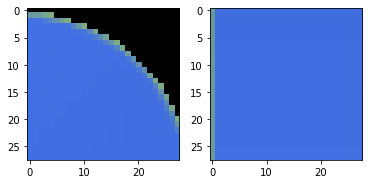

filename = img_1_02_05.png, label = BODY, i = 2, j = 17, Max coeff. = 0.9408290725402094
----------------------------------------------------------


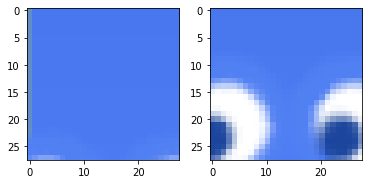

filename = img_1_03_03.png, label = HEAD, i = 3, j = 3, Max coeff. = 0.4749948922912958
----------------------------------------------------------


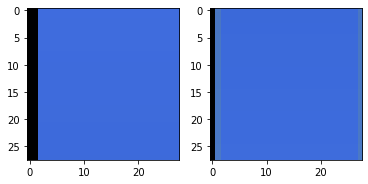

filename = img_1_03_05.png, label = BODY, i = 2, j = 16, Max coeff. = 0.8375658170754222
----------------------------------------------------------


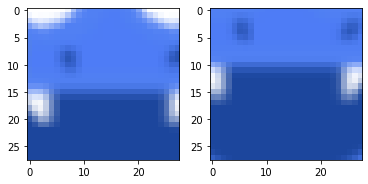

filename = img_1_04_03.png, label = HEAD, i = 3, j = 2, Max coeff. = 0.9413416844901669
----------------------------------------------------------


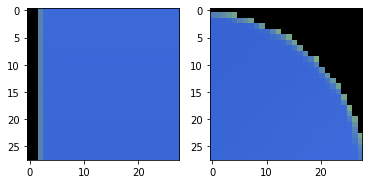

filename = img_1_04_05.png, label = BODY, i = 2, j = 5, Max coeff. = 0.8025702536891188
----------------------------------------------------------


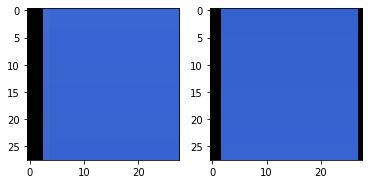

filename = img_1_05_05.png, label = BODY, i = 2, j = 13, Max coeff. = 0.5635828472877283
----------------------------------------------------------


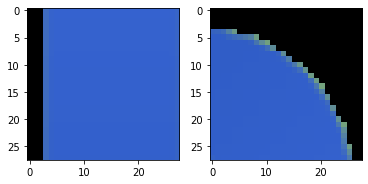

filename = img_1_06_05.png, label = BODY, i = 2, j = 11, Max coeff. = 0.30492226612638856
----------------------------------------------------------


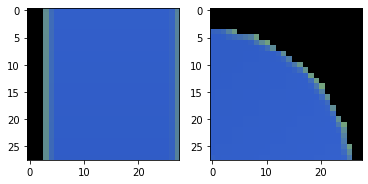

filename = img_1_07_05.png, label = BODY, i = 2, j = 11, Max coeff. = 0.3529989851584238
----------------------------------------------------------


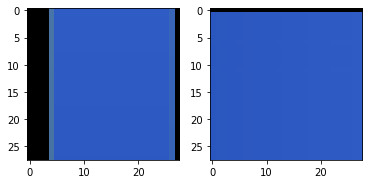

filename = img_1_08_05.png, label = BODY, i = 2, j = 8, Max coeff. = 0.9479579045577836
----------------------------------------------------------


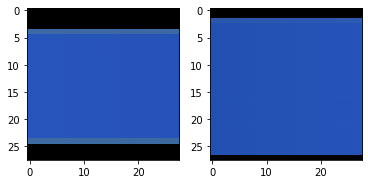

filename = img_1_09_06.png, label = BODY, i = 2, j = 1, Max coeff. = 0.23514100806906865
----------------------------------------------------------


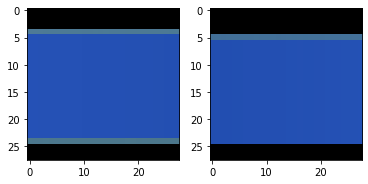

filename = img_1_09_07.png, label = BODY, i = 2, j = 9, Max coeff. = 0.8658886945038579
----------------------------------------------------------


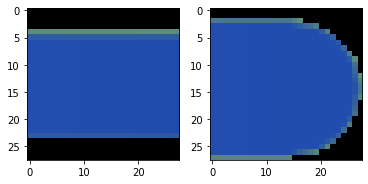

filename = img_1_09_08.png, label = BODY, i = 2, j = 0, Max coeff. = 0.9451207559048775
----------------------------------------------------------


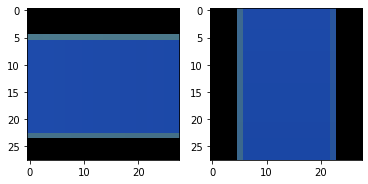

filename = img_1_09_09.png, label = BODY, i = 2, j = 12, Max coeff. = 0.4691964125337758
----------------------------------------------------------


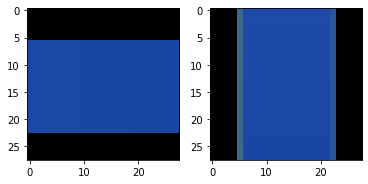

filename = img_1_09_10.png, label = BODY, i = 2, j = 12, Max coeff. = 0.6052918483082917
----------------------------------------------------------


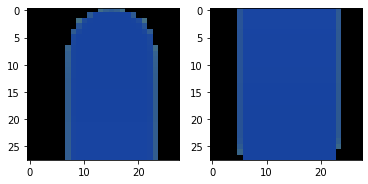

filename = img_2_07_11.png, label = BODY, i = 2, j = 20, Max coeff. = 0.9786116223962332
----------------------------------------------------------


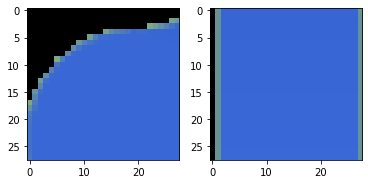

filename = img_2_08_02.png, label = BODY, i = 2, j = 15, Max coeff. = 0.854942873855325
----------------------------------------------------------


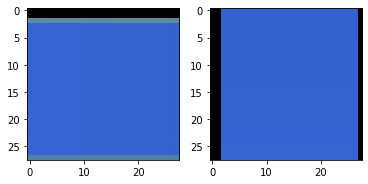

filename = img_2_08_03.png, label = BODY, i = 2, j = 13, Max coeff. = 0.935196988331865
----------------------------------------------------------


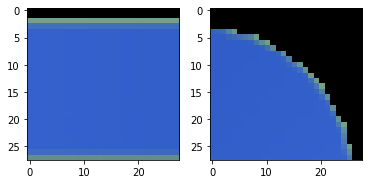

filename = img_2_08_04.png, label = BODY, i = 2, j = 11, Max coeff. = 0.7084237806741593
----------------------------------------------------------


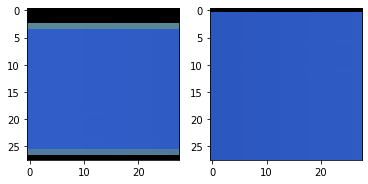

filename = img_2_08_05.png, label = BODY, i = 2, j = 8, Max coeff. = 0.2578460006168608
----------------------------------------------------------


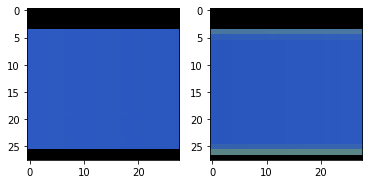

filename = img_2_08_06.png, label = BODY, i = 2, j = 10, Max coeff. = 0.7537408374587257
----------------------------------------------------------


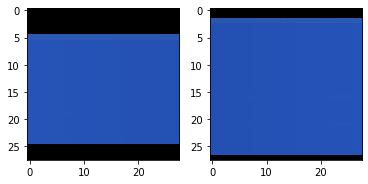

filename = img_2_08_08.png, label = BODY, i = 2, j = 1, Max coeff. = 0.9599178249761611
----------------------------------------------------------


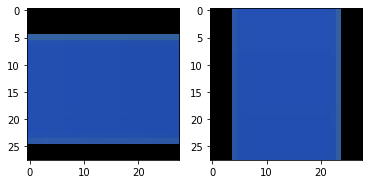

filename = img_2_08_09.png, label = BODY, i = 2, j = 7, Max coeff. = 0.8244327976201798
----------------------------------------------------------


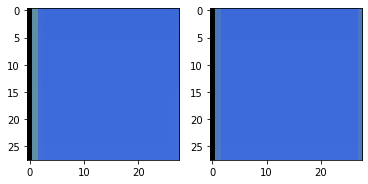

filename = img_2_09_02.png, label = BODY, i = 2, j = 16, Max coeff. = 0.9804906967894977
----------------------------------------------------------


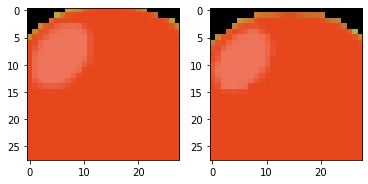

filename = img_2_09_10.png, label = APPL, i = 1, j = 4, Max coeff. = 0.9999211987374066
----------------------------------------------------------


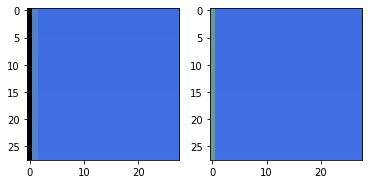

filename = img_2_10_02.png, label = BODY, i = 2, j = 17, Max coeff. = 1.0
----------------------------------------------------------


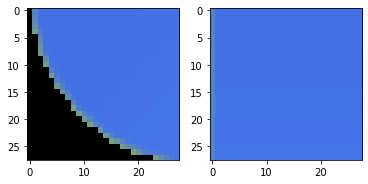

filename = img_2_11_02.png, label = BODY, i = 2, j = 18, Max coeff. = 0.936585902454345
----------------------------------------------------------


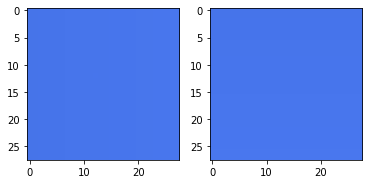

filename = img_2_11_03.png, label = BODY, i = 2, j = 19, Max coeff. = 0.9061029400704957
----------------------------------------------------------


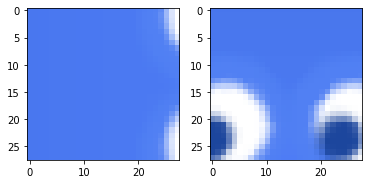

filename = img_2_11_04.png, label = HEAD, i = 3, j = 3, Max coeff. = 0.5163379480236324
----------------------------------------------------------


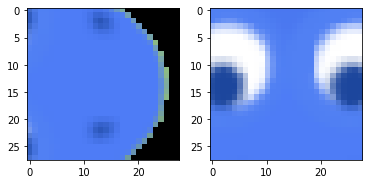

filename = img_2_11_05.png, label = HEAD, i = 3, j = 0, Max coeff. = 0.8110269653261994
----------------------------------------------------------


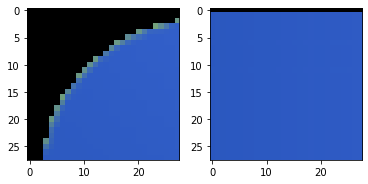

filename = img_3_02_11.png, label = BODY, i = 2, j = 8, Max coeff. = 0.5240309633566905
----------------------------------------------------------


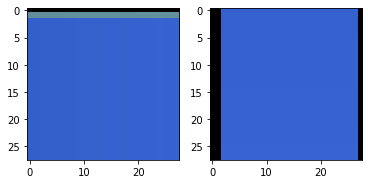

filename = img_3_02_12.png, label = BODY, i = 2, j = 13, Max coeff. = 0.5659180299257895
----------------------------------------------------------


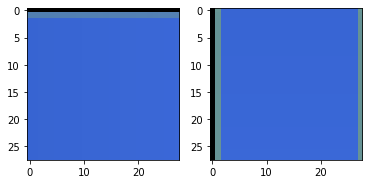

filename = img_3_02_13.png, label = BODY, i = 2, j = 15, Max coeff. = 0.9364262657812684
----------------------------------------------------------


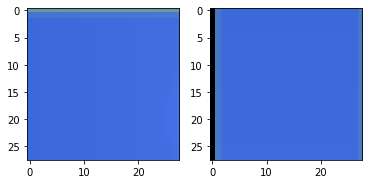

filename = img_3_02_14.png, label = BODY, i = 2, j = 16, Max coeff. = 0.6097352257671734
----------------------------------------------------------


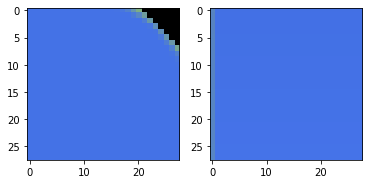

filename = img_3_02_15.png, label = BODY, i = 2, j = 18, Max coeff. = 0.8841730002596413
----------------------------------------------------------


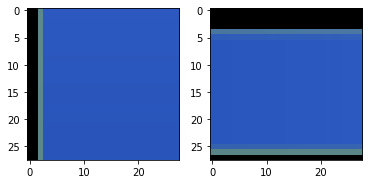

filename = img_3_03_11.png, label = BODY, i = 2, j = 10, Max coeff. = 0.529151974104152
----------------------------------------------------------


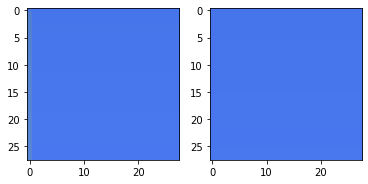

filename = img_3_03_15.png, label = BODY, i = 2, j = 19, Max coeff. = 0.9514037970871859
----------------------------------------------------------


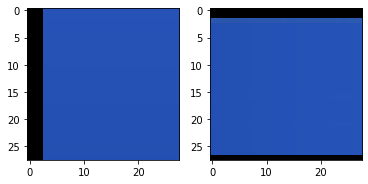

filename = img_3_04_11.png, label = BODY, i = 2, j = 1, Max coeff. = 0.8723807870972949
----------------------------------------------------------


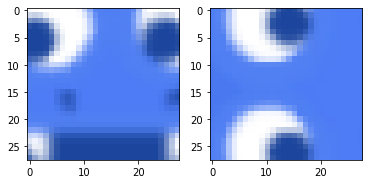

filename = img_3_04_15.png, label = HEAD, i = 3, j = 1, Max coeff. = 0.8991194065074638
----------------------------------------------------------


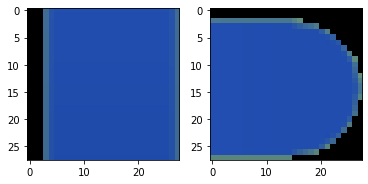

filename = img_3_05_11.png, label = BODY, i = 2, j = 0, Max coeff. = 0.5730316172876393
----------------------------------------------------------


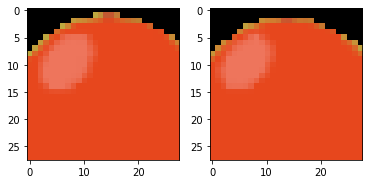

filename = img_3_06_04.png, label = APPL, i = 1, j = 9, Max coeff. = 0.999732644432639
----------------------------------------------------------


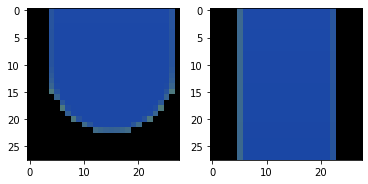

filename = img_3_06_11.png, label = BODY, i = 2, j = 12, Max coeff. = 0.7977595454642742
----------------------------------------------------------


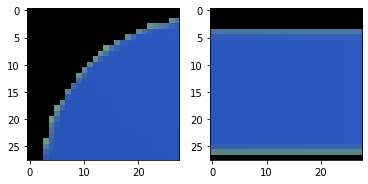

filename = img_4_03_09.png, label = BODY, i = 2, j = 10, Max coeff. = 0.5468808818835355
----------------------------------------------------------


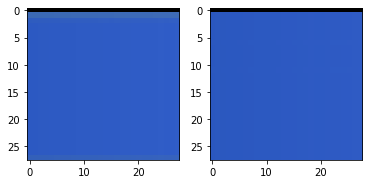

filename = img_4_03_10.png, label = BODY, i = 2, j = 8, Max coeff. = 0.5235578496173751
----------------------------------------------------------


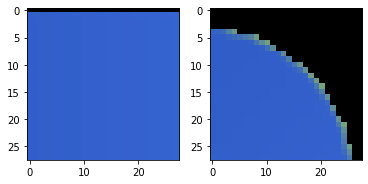

filename = img_4_03_11.png, label = BODY, i = 2, j = 11, Max coeff. = 0.40904756412125837
----------------------------------------------------------


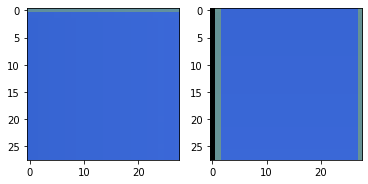

filename = img_4_03_12.png, label = BODY, i = 2, j = 15, Max coeff. = 0.9809979075176908
----------------------------------------------------------


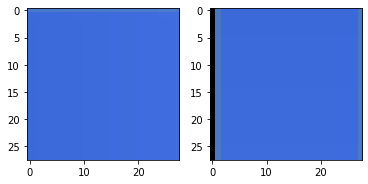

filename = img_4_03_13.png, label = BODY, i = 2, j = 16, Max coeff. = 0.613533816795694
----------------------------------------------------------


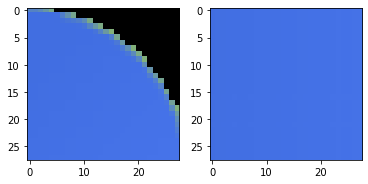

filename = img_4_03_14.png, label = BODY, i = 2, j = 2, Max coeff. = 0.9294447220862164
----------------------------------------------------------


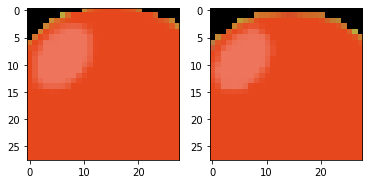

filename = img_4_03_15.png, label = APPL, i = 1, j = 4, Max coeff. = 0.9998433850020066
----------------------------------------------------------


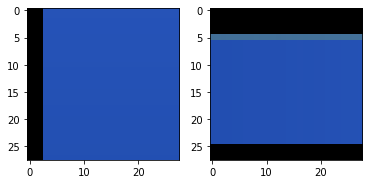

filename = img_4_04_09.png, label = BODY, i = 2, j = 9, Max coeff. = 0.8762976133080645
----------------------------------------------------------


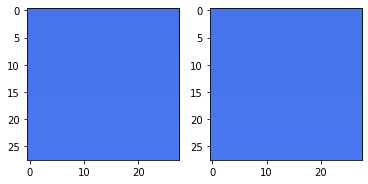

filename = img_4_04_14.png, label = BODY, i = 2, j = 19, Max coeff. = 0.9706375562725129
----------------------------------------------------------


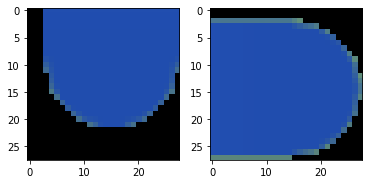

filename = img_4_05_09.png, label = BODY, i = 2, j = 0, Max coeff. = 0.9126823128589189
----------------------------------------------------------


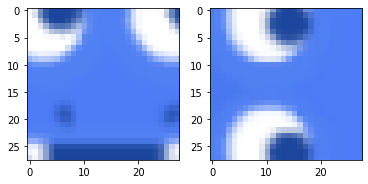

filename = img_4_05_14.png, label = HEAD, i = 3, j = 1, Max coeff. = 0.9600422257626539
----------------------------------------------------------


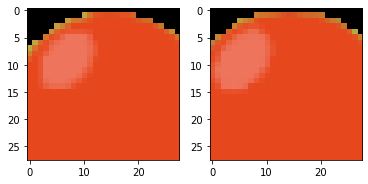

filename = img_5_01_15.png, label = APPL, i = 1, j = 4, Max coeff. = 0.9998332568834666
----------------------------------------------------------


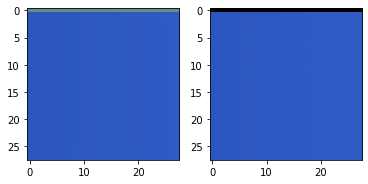

filename = img_5_09_10.png, label = BODY, i = 2, j = 8, Max coeff. = 0.8439884239053509
----------------------------------------------------------


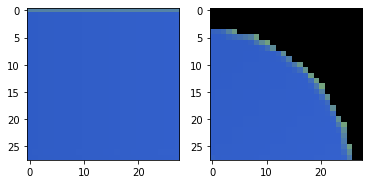

filename = img_5_09_11.png, label = BODY, i = 2, j = 11, Max coeff. = 0.7040009594094013
----------------------------------------------------------


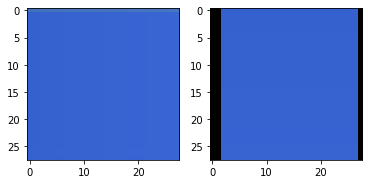

filename = img_5_09_12.png, label = BODY, i = 2, j = 13, Max coeff. = 0.7502608124786413
----------------------------------------------------------


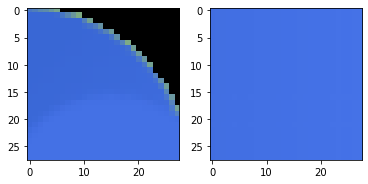

filename = img_5_09_13.png, label = BODY, i = 2, j = 2, Max coeff. = 0.7264938088833977
----------------------------------------------------------


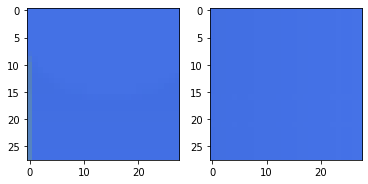

filename = img_5_10_13.png, label = BODY, i = 2, j = 2, Max coeff. = 0.7395846835844445
----------------------------------------------------------


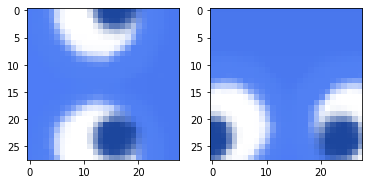

filename = img_5_11_12.png, label = HEAD, i = 3, j = 3, Max coeff. = 0.8414755551793774
----------------------------------------------------------


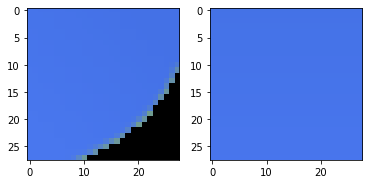

filename = img_5_11_13.png, label = BODY, i = 2, j = 4, Max coeff. = 0.8281478935373752
----------------------------------------------------------


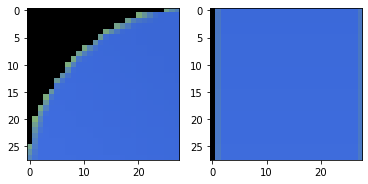

filename = img_6_03_08.png, label = BODY, i = 2, j = 16, Max coeff. = 0.8254691844922938
----------------------------------------------------------


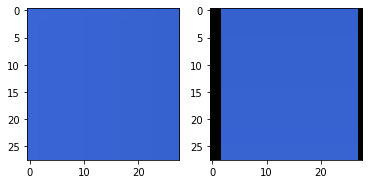

filename = img_6_03_09.png, label = BODY, i = 2, j = 13, Max coeff. = 0.8172486836105097
----------------------------------------------------------


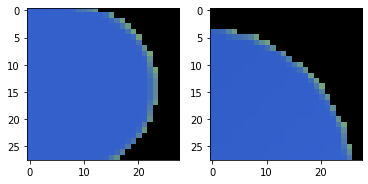

filename = img_6_03_10.png, label = BODY, i = 2, j = 11, Max coeff. = 0.7548263454717418
----------------------------------------------------------


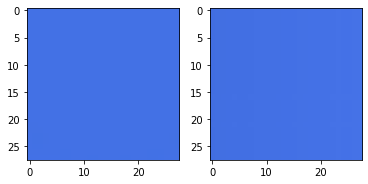

filename = img_6_04_08.png, label = BODY, i = 2, j = 2, Max coeff. = 0.7698550097973532
----------------------------------------------------------


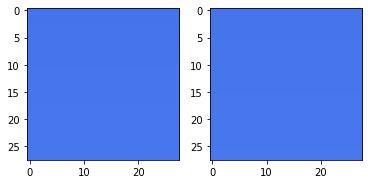

filename = img_6_05_08.png, label = BODY, i = 2, j = 19, Max coeff. = 0.9305043966885153
----------------------------------------------------------


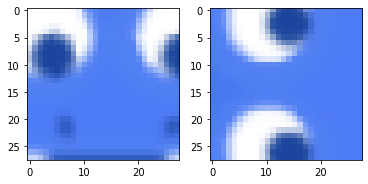

filename = img_6_06_08.png, label = HEAD, i = 3, j = 1, Max coeff. = 0.9586133194813349
----------------------------------------------------------


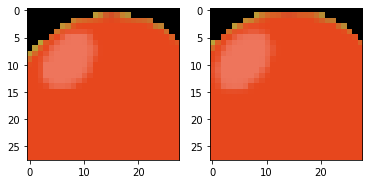

filename = img_6_12_13.png, label = APPL, i = 1, j = 3, Max coeff. = 0.9997616362890668
----------------------------------------------------------


In [34]:
sample_folder_path = "img_probe"
subfolder_path = [f"{sample_folder_path}/img_{i}/" for i in range(7)]

threshold = 0
hist_all_label = []
img_all_label = []
hist_all_label, img_all_label = calc_all_hist()

for path in subfolder_path:
    for filename in os.listdir(path):
        img = cv2.imread(path + filename)
        img = crop_img(img)
        
        img_label, img_no, max_coeff = predict_img_label(img, hist_all_label, threshold)
        
        if(img_label!=-1 and img_label!=0):
            fig, axes = plt.subplots(ncols=2, nrows=1)
            axes[0].imshow(img[::,::,::-1])
            axes[1].imshow(img_all_label[img_label][img_no][::,::,::-1])
            plt.show()
            plt.close()
            print(f"filename = {filename}, label = {label_str[img_label]}, i = {img_label}, j = {img_no}, Max coeff. = {max_coeff}")
            print('----------------------------------------------------------')
    print('========================================================================================')

In [ ]:
img_no = 1
img_filename = f"img_{img_no}_03_03.png"

folder_path = f"img_probe/img_{img_no}"
img_path = f"{folder_path}/{img_filename}"

img_i = cv2.imread(img_path)
img_i = img_i[upper_t:lower_t, left_t:right_t]

hist_i = calc_hist(img_i)

x = 2
y = 18

sum_diff = 0
for chan in range(3):
    diff = cv2.compareHist(hist_i[chan], hist_all_label[x][y][chan], cv2.HISTCMP_CORREL)
    print(diff)
    sum_diff += diff
print('--------------------')
print(sum_diff/3)
    
# plot histograms and show images
plot_hist(hist_i)
plot_hist(hist_all_label[x][y])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5,12))
axes[0].imshow(img_i[::,::,::-1])
axes[1].imshow(img_all_label[x][y][::,::,::-1])
plt.show()
plt.close()

# Evaluation**

In [42]:
folder_path = "img_probe_labeled"
labels = [str(i) for i in range(4)]
label_str = ['BG', 'APPL', 'BODY', 'HEAD']

threshold = 0
hist_all_label, img_all_label = calc_all_hist()

# array of labels
predicted = []
ground_truth = []

for label in labels:
    probe_folder_path = f"{folder_path}/{label}/"
    for filename in os.listdir(probe_folder_path):
        img = cv2.imread(probe_folder_path + filename)
        img = crop_img(img)
        img_label, img_no, coeff = predict_img_label(img, hist_all_label, threshold)
        
        ground_truth.append(int(label))
        predicted.append(img_label)

## Confusion Matrix

In [43]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [45]:
def show_conf_matrix(y_test, y_pred, labels):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=labels, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [46]:
def show_clf_report(y_test, y_pred, labels):
    print(classification_report(y_test, y_pred, target_names=labels))

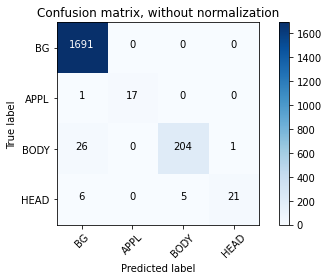

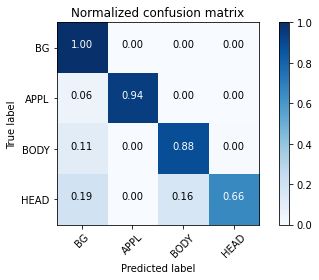

              precision    recall  f1-score   support

          BG       0.98      1.00      0.99      1691
        APPL       1.00      0.94      0.97        18
        BODY       0.98      0.88      0.93       231
        HEAD       0.95      0.66      0.78        32

    accuracy                           0.98      1972
   macro avg       0.98      0.87      0.92      1972
weighted avg       0.98      0.98      0.98      1972



In [47]:
show_conf_matrix(ground_truth, predicted, label_str)
show_clf_report(ground_truth, predicted, label_str)